In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, AveragePooling2D,
SpatialDropout2D, RandomRotation, RandomTranslation, RandomFlip, RandomZoom, GaussianNoise, RandomContrast, RandomBrightness)
from tensorflow.keras.optimizers import Adam, AdamW, SGD
from tensorflow.keras.models import Model
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from sklearn.utils import class_weight
from tensorflow.keras.regularizers import l2

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
!nvidia-smi

Num GPUs Available:  1
Mon Apr  7 23:04:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 572.61         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P0             12W /   70W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------

In [6]:
mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)

In [7]:
print(resnet50.preprocess_input.__doc__)


  Preprocesses a tensor or Numpy array encoding a batch of images.

  Usage example with `applications.MobileNet`:

  ```python
  i = keras.layers.Input([None, None, 3], dtype="uint8")
  x = ops.cast(i, "float32")
  x = keras.applications.mobilenet.preprocess_input(x)
  core = keras.applications.MobileNet()
  x = core(x)
  model = keras.Model(inputs=[i], outputs=[x])
  result = model(image)
  ```

  Args:
        x: A floating point `numpy.array` or a backend-native tensor,
            3D or 4D with 3 color
            channels, with values in the range [0, 255].
            The preprocessed data are written over the input data
        if the data types are compatible. To avoid this
        behaviour, `numpy.copy(x)` can be used.
        data_format: Optional data format of the image tensor/array. None, means
        the global setting `keras.backend.image_data_format()` is used
        (unless you changed it, it uses "channels_last").
        Defaults to `None`.

  Returns:
      Pre

In [8]:
# Define paths
train_dir = '/mnt/c/Users/vienn/OneDrive/Escritorio/NCT-CRC-HE-100k-Binary/train'
val_dir = '/mnt/c/Users/vienn/OneDrive/Escritorio/NCT-CRC-HE-100k-Binary/val'
test_dir = '/mnt/c/Users/vienn/OneDrive/Escritorio/CRC-VAL-HE-7k-Binary/test'

# Load datasets
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=42
)

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=42
)

print(ds_train.class_names)

# Define augmentation pipeline (applies only during training)
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.15, fill_mode='reflect'),
    RandomTranslation(0.15, 0.15, fill_mode='reflect'),
    RandomZoom(0.1, fill_mode='reflect'),
    RandomContrast(0.1),
    RandomBrightness(0.1, value_range=(0, 255)),
])

# Preprocessing function with augmentation (for training dataset)
def preprocess_image_train(image, label):
    image = tf.cast(image, tf.float32)
    image = data_augmentation(image, training=True)
    image = preprocess_input(image)
    return image, label

# Preprocessing function for validation & test (no augmentation)
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image, label

# Apply preprocessing & augmentations
ds_train = ds_train.map(preprocess_image_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Optimize dataset performance
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


Found 79999 files belonging to 2 classes.


I0000 00:00:1744089106.567151     468 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 20001 files belonging to 2 classes.
Found 7180 files belonging to 2 classes.
['0_non_cancer', '1_adenocarcinoma']


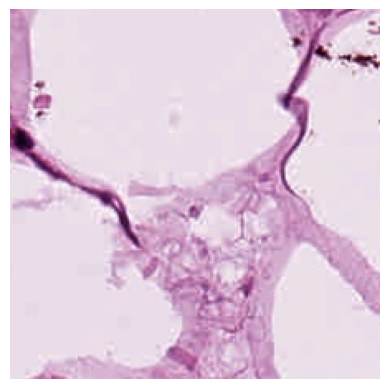

In [26]:
# Sample image
dataset_path = '/mnt/c/Users/vienn/OneDrive/Escritorio/NCT-CRC-HE-100k-Binary/train'
class_folders = os.listdir(dataset_path)

sample_img_path = os.path.join(dataset_path, class_folders[0], os.listdir(os.path.join(dataset_path, class_folders[0]))[0])
img = cv2.imread(sample_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.show()

In [27]:
# Load ResNet without the fully connected layers, keep pretrained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze ResNet layers so they don’t get updated during training
base_model.trainable = False

# Build custom head with Flatten + BatchNorm
x = base_model.output

# Build the classifier on top
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Define the new model
model = Model(inputs=base_model.input, outputs=output)

# Display model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_2 (Cast)       │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ cast_2[0][0]      │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c

 Total params: 24,647,553 (94.02 MB)

 Trainable params: 1,054,721 (4.02 MB)

 Non-trainable params: 23,592,832 (90.00 MB)

In [28]:
# Define class distribution
class_names = ['0_non_cancer', '1_adenocarcinoma']
num_samples = [68546, 11453]  # Number of samples per class

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),  # Binary classes: 0 (0_non_cancer), 1 (1_adenocarcinoma)
    y=np.concatenate([np.zeros(num_samples[0]), np.ones(num_samples[1])])  # Labels
)

# Convert to dictionary format for Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weight_dict)


Class Weights: {0: np.float64(0.5835424386543343), 1: np.float64(3.492491050379813)}


In [29]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop training if val_loss doesn't improve for 5 epochs
    restore_best_weights=True  # Restore best model (avoid last overfitted epoch)
)

In [30]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce LR by half
    patience=2,  # If no improvement for 2 epochs
    min_lr=1e-6  # Don't let it go too low
)

In [31]:
checkpoint_callback = ModelCheckpoint(
    filepath='/mnt/c/Users/vienn/OneDrive/Escritorio/resnet50_model.keras',  # Save path
    monitor='val_loss',        # Track validation loss
    save_best_only=True,       # Save only when val_loss improves
    mode='min',                # 'min' for loss, 'max' for accuracy
)

In [32]:
model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [33]:
history = model.fit(
    ds_train,
    epochs=15,
    validation_data=ds_val,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, lr_scheduler, checkpoint_callback]
)

Epoch 1/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 266s 102ms/step - accuracy: 0.9221 - loss: 0.1657 - precision: 0.6735 - recall: 0.9531 - val_accuracy: 0.9668 - val_loss: 0.0865 - val_precision: 0.8163 - val_recall: 0.9913 - learning_rate: 1.0000e-04
Epoch 2/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 249s 99ms/step - accuracy: 0.9694 - loss: 0.0826 - precision: 0.8400 - recall: 0.9705 - val_accuracy: 0.9765 - val_loss: 0.0615 - val_precision: 0.8640 - val_recall: 0.9916 - learning_rate: 1.0000e-04
Epoch 3/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 231s 92ms/step - accuracy: 0.9729 - loss: 0.0717 - precision: 0.8551 - recall: 0.9755 - val_accuracy: 0.9751 - val_loss: 0.0626 - val_precision: 0.8561 - val_recall: 0.9930 - learning_rate: 1.0000e-04
Epoch 4/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 256s 90ms/step - accuracy: 0.9745 - loss: 0.0650 - precision: 0.8619 - recall: 0.9784 - val_accuracy: 0.9792 - val_loss: 0.0549 - val_precision: 0.8773 - val_recall: 0.9937 - learning_rate: 1.0000e-04
Epoch 5/15
2500/2500 ━━━━━━

In [34]:
# Unfreeze conv4 and conv5
for layer in model.layers[81:]:
    layer.trainable = True

i = 0
for layer in base_model.layers:
    print(f"{i}. {layer.name}: {layer.trainable}")
    i=i+1


0. input_layer_3: False
1. conv1_pad: False
2. conv1_conv: False
3. conv1_bn: False
4. conv1_relu: False
5. pool1_pad: False
6. pool1_pool: False
7. conv2_block1_1_conv: False
8. conv2_block1_1_bn: False
9. conv2_block1_1_relu: False
10. conv2_block1_2_conv: False
11. conv2_block1_2_bn: False
12. conv2_block1_2_relu: False
13. conv2_block1_0_conv: False
14. conv2_block1_3_conv: False
15. conv2_block1_0_bn: False
16. conv2_block1_3_bn: False
17. conv2_block1_add: False
18. conv2_block1_out: False
19. conv2_block2_1_conv: False
20. conv2_block2_1_bn: False
21. conv2_block2_1_relu: False
22. conv2_block2_2_conv: False
23. conv2_block2_2_bn: False
24. conv2_block2_2_relu: False
25. conv2_block2_3_conv: False
26. conv2_block2_3_bn: False
27. conv2_block2_add: False
28. conv2_block2_out: False
29. conv2_block3_1_conv: False
30. conv2_block3_1_bn: False
31. conv2_block3_1_relu: False
32. conv2_block3_2_conv: False
33. conv2_block3_2_bn: False
34. conv2_block3_2_relu: False
35. conv2_block3_3_

In [35]:
early_stopping_fine = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
lr_scheduler_fine = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7
)

In [36]:
model.compile(
    optimizer = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

# Resume training
history_fine = model.fit(
    ds_train,
    epochs=30,
    validation_data=ds_val,
    class_weight=class_weight_dict,
    callbacks=[early_stopping_fine, lr_scheduler_fine, checkpoint_callback]
)

Epoch 1/30


2025-04-08 00:53:43.965362: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bw-filter.29 = (f16[256,1,1,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,28,28,512]{3,2,1,0} %bitcast.38828, f16[32,14,14,256]{3,2,1,0} %bitcast.38711), window={size=1x1 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/functional_3_1/conv4_block1_1_conv_1/convolution/Conv2DBackpropFilter" source_file="/home/axel/myenv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-04-08 00:53:44.015283: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.051

2499/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9639 - loss: 0.1022 - precision: 0.8166 - recall: 0.9655

2025-04-08 00:57:34.055236: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_71', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_77', 8 bytes spill stores, 8 bytes spill loads



2500/2500 ━━━━━━━━━━━━━━━━━━━━ 277s 101ms/step - accuracy: 0.9639 - loss: 0.1021 - precision: 0.8167 - recall: 0.9655 - val_accuracy: 0.9887 - val_loss: 0.0367 - val_precision: 0.9362 - val_recall: 0.9885 - learning_rate: 1.0000e-04
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 301s 120ms/step - accuracy: 0.9809 - loss: 0.0538 - precision: 0.8932 - recall: 0.9838 - val_accuracy: 0.9890 - val_loss: 0.0340 - val_precision: 0.9349 - val_recall: 0.9923 - learning_rate: 1.0000e-04
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 270s 99ms/step - accuracy: 0.9825 - loss: 0.0474 - precision: 0.9035 - recall: 0.9823 - val_accuracy: 0.9909 - val_loss: 0.0274 - val_precision: 0.9452 - val_recall: 0.9937 - learning_rate: 1.0000e-04
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 251s 100ms/step - accuracy: 0.9839 - loss: 0.0428 - precision: 0.9091 - recall: 0.9861 - val_accuracy: 0.9912 - val_loss: 0.0265 - val_precision: 0.9462 - val_recall: 0.9948 - learning_rate: 1.0000e-04
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━

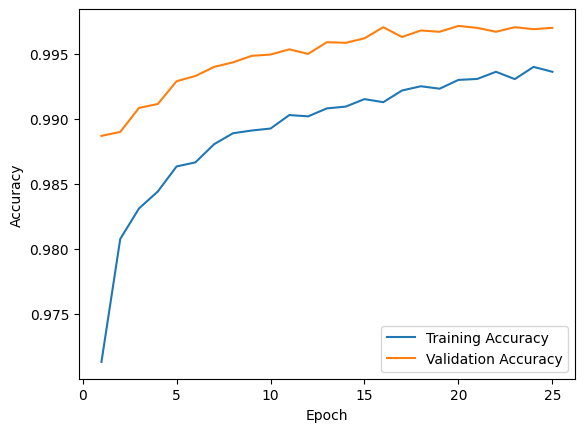

In [37]:
# Model accuracy
accuracy_values = history_fine.history['accuracy']
val_accuracy_values = history_fine.history['val_accuracy']
epoch = range(1, len(accuracy_values) + 1)

plt.plot(epoch, accuracy_values, label='Training Accuracy')
plt.plot(epoch, val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

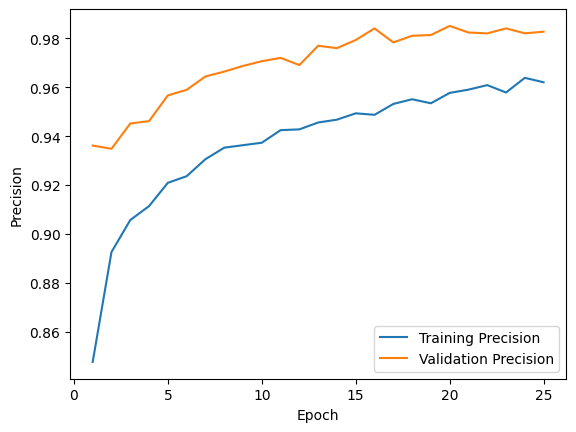

In [38]:
# Model presicion
accuracy_values = history_fine.history['precision']
val_accuracy_values = history_fine.history['val_precision']
epoch = range(1, len(accuracy_values) + 1)

plt.plot(epoch, accuracy_values, label='Training Precision')
plt.plot(epoch, val_accuracy_values, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

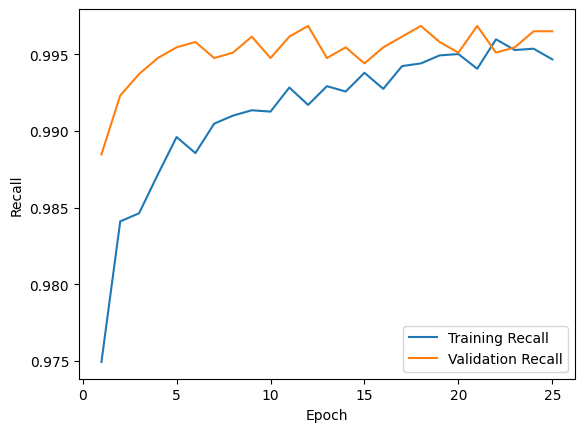

In [39]:
# Model presicion
accuracy_values = history_fine.history['recall']
val_accuracy_values = history_fine.history['val_recall']
epoch = range(1, len(accuracy_values) + 1)

plt.plot(epoch, accuracy_values, label='Training Recall')
plt.plot(epoch, val_accuracy_values, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [41]:
best_model = tf.keras.models.load_model('/mnt/c/Users/vienn/OneDrive/Escritorio/resnet50_model.keras')

In [42]:
import numpy as np
from sklearn.metrics import f1_score, balanced_accuracy_score

# Extract true labels
y_true = np.concatenate([y.numpy() for _, y in ds_val], axis=0)
y_true = y_true.flatten().astype(int)  # Shape: (num_samples,)

# Generate predictions
y_pred_prob = best_model.predict(ds_val).flatten()  # Predicted probabilities
y_pred_class = (y_pred_prob >= 0.5).astype(int)  # Binary classes (0 or 1)

# Calculate metrics
f1 = f1_score(y_true, y_pred_class)
bal_acc = balanced_accuracy_score(y_true, y_pred_class)

print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")

2025-04-08 08:34:48.868269: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


626/626 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step
F1 Score: 0.9903
Balanced Accuracy: 0.9965


In [43]:
# Model evaluation
# Get all outputs
results = best_model.evaluate(ds_test)

test_loss, test_acc, test_precision, test_recall = results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9910 - loss: 0.0289 - precision: 0.1335 - recall: 0.1641

2025-04-08 08:35:37.178474: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1958', 356 bytes spill stores, 436 bytes spill loads

2025-04-08 08:35:37.455316: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1958', 228 bytes spill stores, 228 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9909 - loss: 0.0294 - precision: 0.1440 - recall: 0.1748
Test Loss: 0.0599
Test Accuracy: 0.9812
Test Precision: 0.9269
Test Recall: 0.9667


2025-04-08 08:35:50.822376: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step
Confusion Matrix (Test Set):
 [[5853   94]
 [  41 1192]]


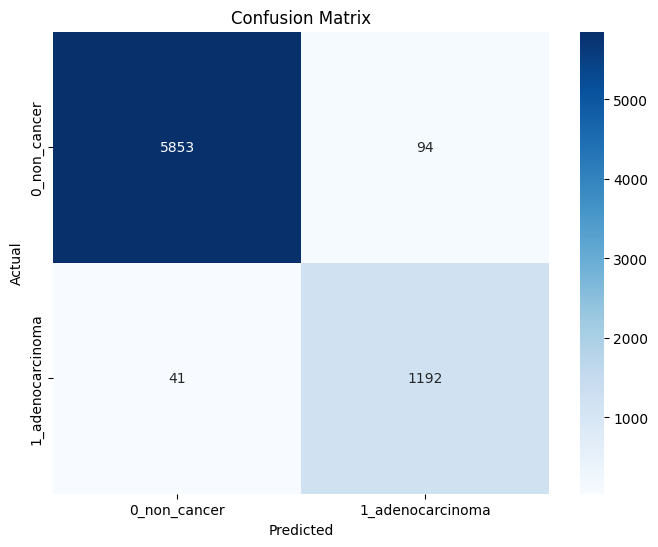

In [44]:
# Get true labels from test dataset
true_labels = np.concatenate([y.numpy() for _, y in ds_test], axis=0)

# Get model predictions
predictions = best_model.predict(ds_test)
predicted_labels = (predictions >= 0.5).astype(int)  # Threshold for binary classification

# Flatten both arrays for confusion matrix
true_labels = true_labels.flatten()
predicted_labels = predicted_labels.flatten()

# Get class names from dataset
class_names = ['0_non_cancer', '1_adenocarcinoma']


# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix (Test Set):\n", cm)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step


2025-04-08 08:36:21.916387: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Test Recall: 0.9765
Test Precision: 0.8985
Test F1: 0.9359
Confusion Matrix (Test Set):
 [[5811  136]
 [  29 1204]]


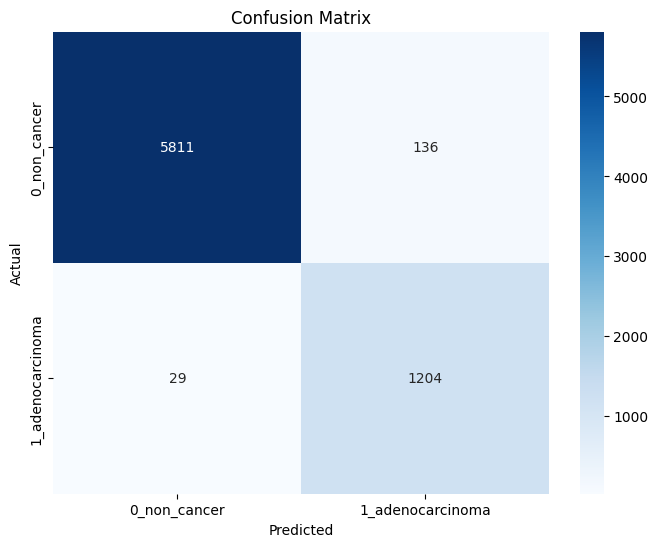

In [45]:
# Predict probabilities for test set
y_pred_prob_test = best_model.predict(ds_test).flatten()

y_true_test = np.concatenate([y.numpy() for _, y in ds_test], axis=0).astype(int)

best_threshold = 0.2
y_pred_class_tuned = (y_pred_prob_test >= best_threshold).astype(int)

# Calculate metrics
from sklearn.metrics import recall_score, precision_score, f1_score

print(f"Test Recall: {recall_score(y_true_test, y_pred_class_tuned):.4f}")
print(f"Test Precision: {precision_score(y_true_test, y_pred_class_tuned):.4f}")
print(f"Test F1: {f1_score(y_true_test, y_pred_class_tuned):.4f}")

# Confusion matrix (optional)
cm = confusion_matrix(y_true_test, y_pred_class_tuned)
print("Confusion Matrix (Test Set):\n", cm)

# Compute confusion matrix
cm = confusion_matrix(y_true_test, y_pred_class_tuned)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [46]:
def grad_cam(model, img_array, layer_name='conv5_block3_out'):
    # Create gradient model
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        # For binary classification (single output node)
        loss = predictions[:, 0]  # Always use index 0 for single output

    # Get gradients
    grads = tape.gradient(loss, conv_outputs)[0]

    # Pool gradients and create heatmap
    weights = tf.reduce_mean(grads, axis=(0, 1))
    heatmap = tf.reduce_sum(weights * conv_outputs, axis=-1)[0]

    # Post-process heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    return heatmap

def overlay_heatmap(img, heatmap, alpha=0.4):
    # Rescale heatmap to 0-255 and apply colormap
    heatmap = np.uint8(255 * heatmap)
    jet = plt.colormaps.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    return superimposed_img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


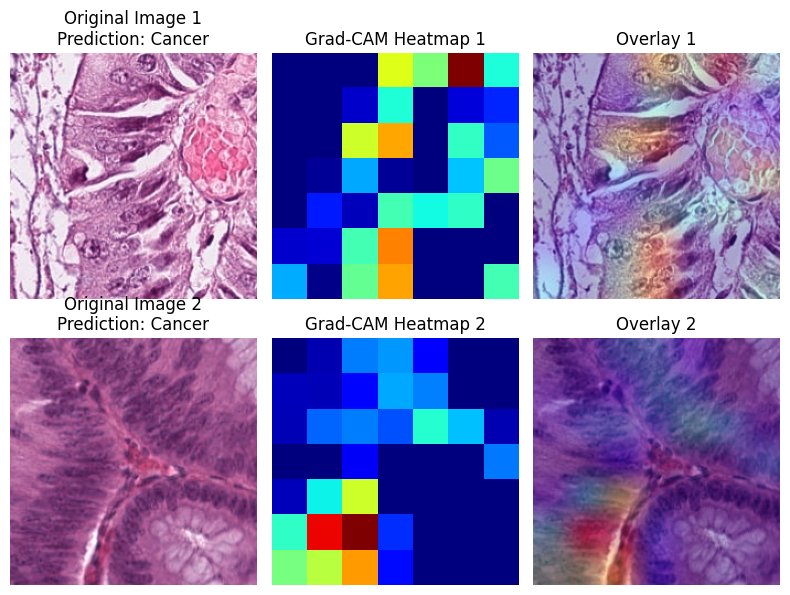

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define paths to the two images
img_paths = [
    '/mnt/c/Users/vienn/OneDrive/Escritorio/CRC-VAL-HE-7k-Binary/test/1_adenocarcinoma/TUM-TCGA-AIHSVASQ.jpg',
    '/mnt/c/Users/vienn/OneDrive/Escritorio/CRC-VAL-HE-7k-Binary/test/1_adenocarcinoma/TUM-TCGA-ASNPITVV.jpg'
]

results = []

# Process both images
for img_path in img_paths:
    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array_processed = preprocess_input(img_array.copy())
    img_array_processed = np.expand_dims(img_array_processed, axis=0)

    # Get prediction
    preds = best_model.predict(img_array_processed)
    pred_class = 1 if preds[0] > 0.5 else 0

    # Generate Grad-CAM heatmap
    heatmap = grad_cam(best_model, img_array_processed)

    # Create overlay
    original_img = img_to_array(img)  # Non-preprocessed image for display
    superimposed_img = overlay_heatmap(original_img, heatmap)

    results.append((original_img, heatmap, superimposed_img, pred_class))

# Plot both images in a 2x3 grid
plt.figure(figsize=(8, 6))  # Adjust figure size for two rows

for i, (orig_img, heatmap, superimposed_img, pred_class) in enumerate(results):
    # Original Image
    plt.subplot(2, 3, 3*i + 1)
    plt.imshow(orig_img / 255.0)
    plt.title(f'Original Image {i+1}\nPrediction: {"Cancer" if pred_class == 1 else "Benign"}')
    plt.axis('off')

    # Heatmap
    plt.subplot(2, 3, 3*i + 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title(f'Grad-CAM Heatmap {i+1}')
    plt.axis('off')

    # Overlay
    plt.subplot(2, 3, 3*i + 3)
    plt.imshow(superimposed_img)
    plt.title(f'Overlay {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()